# Libraries

In [1]:
import os
import warnings
import sys
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from urllib.parse import urlparse
import mlflow
from mlflow.models import infer_signature
import mlflow.sklearn
from wordcloud import WordCloud, STOPWORDS
import string

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

mlflow.autolog()



sys.path.append(str(Path.cwd().parent))
""" from settings.params import (DATA_DIR_INPUT,
                             DATA_DIR_OUTPUT,
                             MODEL_PARAMS,
                             REPORT_DIR,
                             TIMEZONE,
                            ) """

2023/08/21 16:01:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


' from settings.params import (DATA_DIR_INPUT,\n                             DATA_DIR_OUTPUT,\n                             MODEL_PARAMS,\n                             REPORT_DIR,\n                             TIMEZONE,\n                            ) '

# Dataset

In [2]:
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data\sample_submission.csv
../data\test.csv
../data\train.csv


In [3]:
data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
data.describe(include="all")

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [7]:
data.shape

(7613, 5)

In [8]:
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
data.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

# Data Visualization

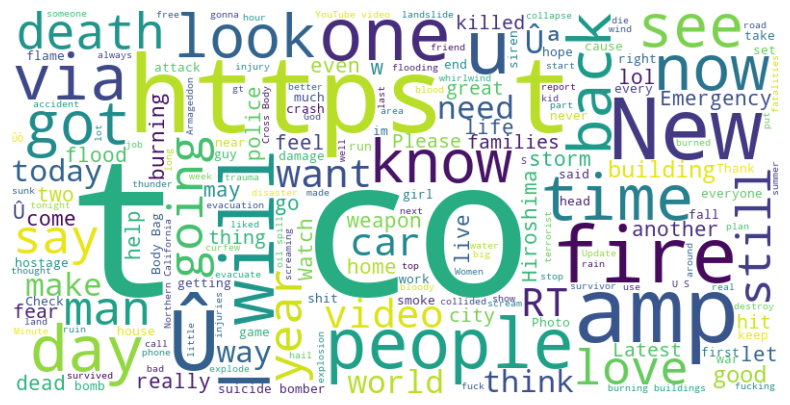

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_text = " ".join(text for text in data["text"])

# Générer un word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

#  Affichage du wordcloud en utilisant matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Target Variable Distribution

The target values denote whether a tweet is about a real disaster (1) or not (0)

In [11]:
x=data.target.value_counts()
x

target
0    4342
1    3271
Name: count, dtype: int64

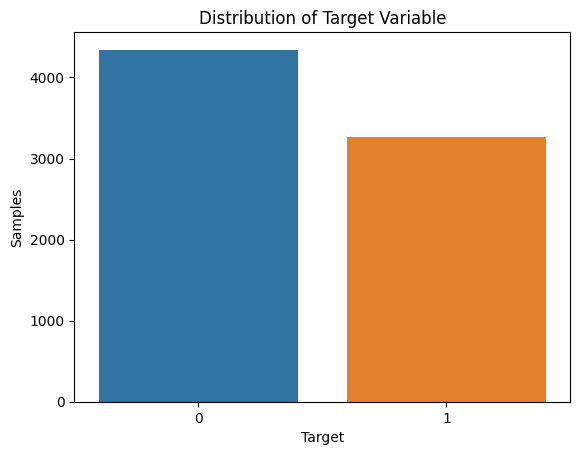

In [12]:
x = data["target"].value_counts()


sns.barplot(x=x.index, y=x)
plt.ylabel('Samples')
plt.xlabel('Target')
plt.title('Distribution of Target Variable')
plt.show()



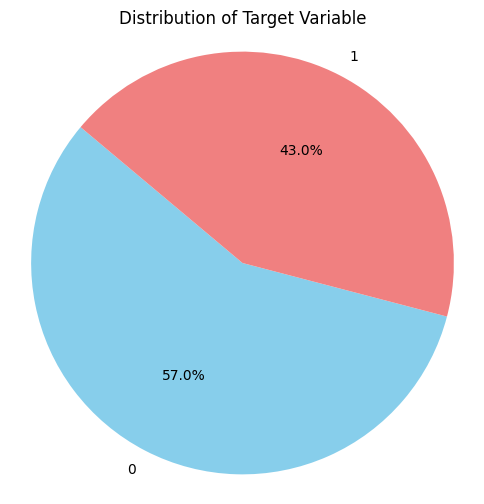

In [13]:
plt.figure(figsize=(6, 6))
plt.pie(x, labels=x.index, autopct="%1.1f%%", startangle=140, colors=["skyblue", "lightcoral"])
plt.title('Distribution of Target Variable')
plt.axis("equal")  
plt.show()

### The distribution of the target variable based on different keywords in the DataFrame

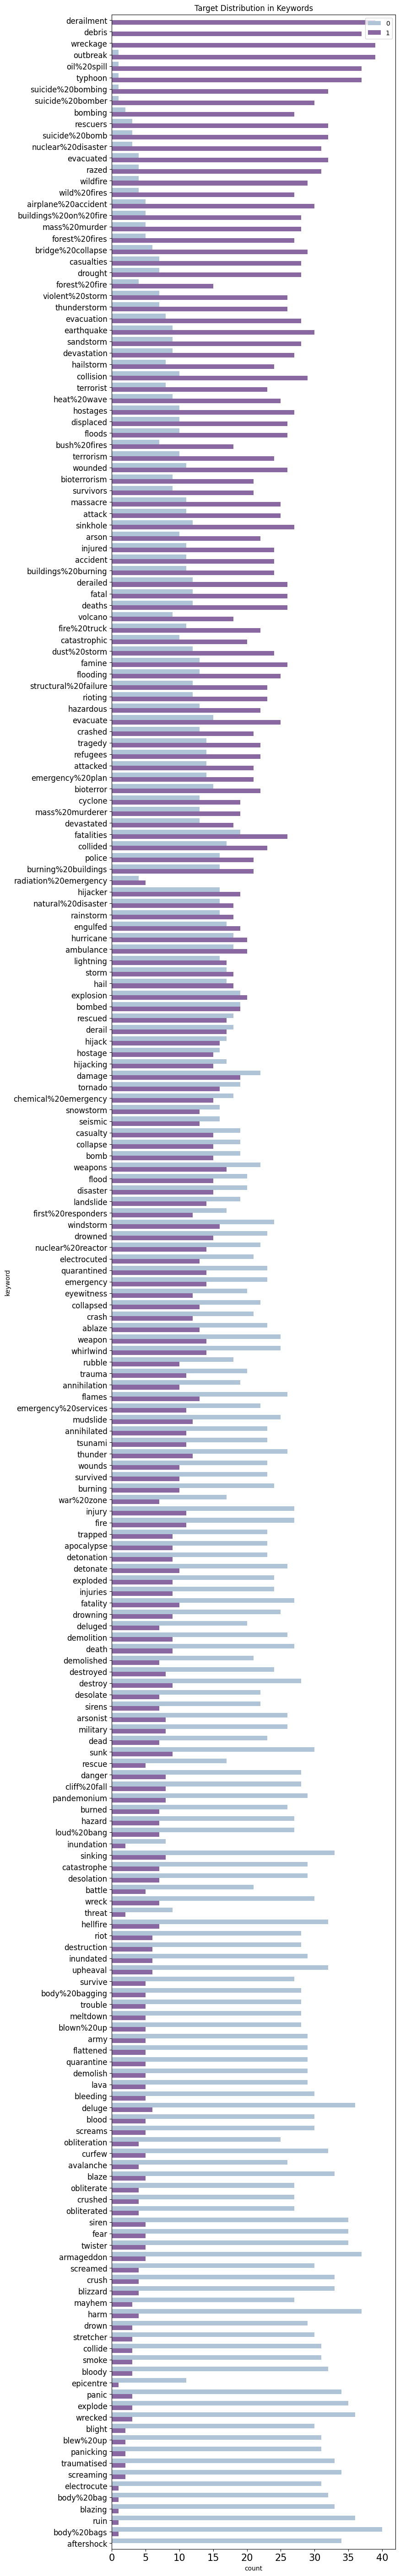

In [14]:

# Calculate the mean target value for each keyword
data['target_mean'] = data.groupby('keyword')['target'].transform('mean')

# Sort the DataFrame by target_mean in descending order
data_sorted = data.sort_values(by='target_mean', ascending=False)

# Create the figure and plot
fig = plt.figure(figsize=(8, 72), dpi=100)
sns.countplot(
    y=data_sorted['keyword'],
    hue=data_sorted['target'],
    palette="BuPu"
)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')
plt.show()

# Drop the temporary 'target_mean' column
data.drop(columns=['target_mean'], inplace=True)


### The top 15 keywords based on their frequencies in the DataFrame

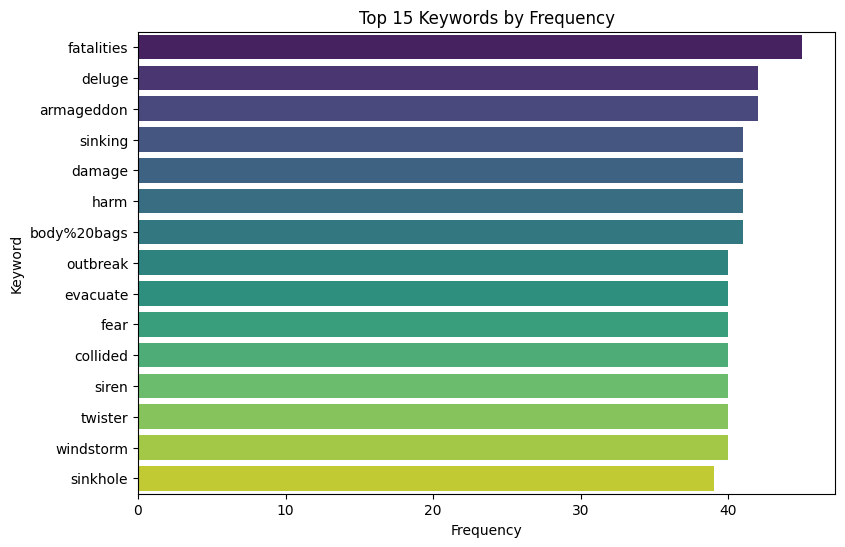

In [15]:
plt.figure(figsize=(9, 6))
sns.countplot(
    y=data['keyword'],
    order=data['keyword'].value_counts().iloc[:15].index,
    palette="viridis"  # You can customize the color palette if desired
)
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.title('Top 15 Keywords by Frequency')
plt.show()


# Data Preprocessing

In [16]:
data.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [17]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## Data Tokenisation

In [18]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')  # Téléchargement des données nécessaires pour la tokenisation


text_column = 'text'  


data['tokenized_text'] = data[text_column].apply(word_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\polytech\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Suppression des stopwords

In [19]:
from nltk.corpus import stopwords

tokenized_text_column = 'tokenized_text'  

# Obtenir la liste des stopwords
stop_words = set(stopwords.words('english')) 

# Appliquer la suppression des stopwords à chaque liste de tokens dans la colonne
data['cleaned_text'] = data[tokenized_text_column].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

print(data)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as ...       1   
...                                                 ...     ...   
7608  Two giant cranes holding a bridge collapse int...       1   
7609  @aria_ahrary @TheTawniest The out of control w...       1   
7610  M1.94 

In [20]:
data['cleaned_text']

0       [Deeds, Reason, #, earthquake, May, ALLAH, For...
1        [Forest, fire, near, La, Ronge, Sask, ., Canada]
2       [residents, asked, 'shelter, place, ', notifie...
3       [13,000, people, receive, #, wildfires, evacua...
4       [got, sent, photo, Ruby, #, Alaska, smoke, #, ...
                              ...                        
7608    [Two, giant, cranes, holding, bridge, collapse...
7609    [@, aria_ahrary, @, TheTawniest, control, wild...
7610    [M1.94, [, 01:04, UTC, ], ?, 5km, Volcano, Haw...
7611    [Police, investigating, e-bike, collided, car,...
7612    [Latest, :, Homes, Razed, Northern, California...
Name: cleaned_text, Length: 7613, dtype: object

## Stemming des données 
Le stemming est le processus de réduction des mots à leur forme de base ou racine, ce qui permet de regrouper différentes formes d'un même mot ensemble. Par exemple, les mots "running", "ran" et "runs" seraient réduits à la racine "run".

In [21]:
from nltk.stem import PorterStemmer

cleaned_text_column = 'cleaned_text'  

# Instancier le stemmer de Porter
stemmer = PorterStemmer()

# Appliquer le stemming à chaque liste de mots dans la colonne
data['stemmed_text'] = data[cleaned_text_column].apply(lambda words: [stemmer.stem(word) for word in words])

print(data)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as ...       1   
...                                                 ...     ...   
7608  Two giant cranes holding a bridge collapse int...       1   
7609  @aria_ahrary @TheTawniest The out of control w...       1   
7610  M1.94 

In [22]:
data['cleaned_text']

0       [Deeds, Reason, #, earthquake, May, ALLAH, For...
1        [Forest, fire, near, La, Ronge, Sask, ., Canada]
2       [residents, asked, 'shelter, place, ', notifie...
3       [13,000, people, receive, #, wildfires, evacua...
4       [got, sent, photo, Ruby, #, Alaska, smoke, #, ...
                              ...                        
7608    [Two, giant, cranes, holding, bridge, collapse...
7609    [@, aria_ahrary, @, TheTawniest, control, wild...
7610    [M1.94, [, 01:04, UTC, ], ?, 5km, Volcano, Haw...
7611    [Police, investigating, e-bike, collided, car,...
7612    [Latest, :, Homes, Razed, Northern, California...
Name: cleaned_text, Length: 7613, dtype: object

# Entrainement des modeles

In [23]:
def define_pipeline(numeric_transformer,
                   categorical_transformer,
                   **kwargs):
    preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),])
    model = Pipeline(
    steps=[("preprocessor", preprocessor), ("model_name", kwargs.get('model_name'))]
    )
    return model

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


def define_pipeline(numeric_transformer, categorical_transformer, model_name, numerical_features, categorical_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    model = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", model_name)]
    )
    return model


numerical_features = ['numerical_column1', 'numerical_column2', ...]  
categorical_features = ['categorical_column1', 'categorical_column2', ...]  

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="undefined"),
    OneHotEncoder(handle_unknown="ignore")
)


## Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

pipeline_LR = define_pipeline(numeric_transformer, categorical_transformer, LogisticRegression, numerical_features, categorical_features)
pipeline_LR

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['numerical_column1',
                                                   'numerical_column2',
                                                   Ellipsis]),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['categorical_column1',
                                                   'categorical_column2',
                                                   Ellipsis])])),
                ('model',
                 <class 'sklearn.linear_model._logistic.LogisticRegression'>)])

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer




X = data['cleaned_text'].apply(' '.join)
y = data['target']



tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_tfidf = tfidf_vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

accuracy = model_LR.score(X_test, y_test)
print("Accuracy:", accuracy)

2023/08/21 16:03:06 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2023/08/21 16:03:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f484d5b052174ce7ad92d4c7507ea118', which will track hyperparameters, performance metrics, model artifacts,

Accuracy: 0.7925147734734077


## RandomForestClassifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

pipeline_RF = define_pipeline(numeric_transformer, categorical_transformer, RandomForestClassifier, numerical_features, categorical_features)
pipeline_RF

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['numerical_column1',
                                                   'numerical_column2',
                                                   Ellipsis]),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['categorical_column1',
                                                   'categorical_column2',
                                                   Ellipsis])])),
                ('model',
                 <class 'sklearn.ensemble._forest.RandomForestClassifier'>)])

In [29]:
# Create a RandomForestClassifier model
model_RF = RandomForestClassifier(random_state=42)  # You can adjust hyperparameters as needed

# Fit the model on the training data
model_RF.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = model_RF.score(X_test, y_test)
print("Accuracy:", accuracy)

2023/08/21 16:03:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '630c2c0e48d041ff932800343f34f872', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/08/21 16:03:23 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


Accuracy: 0.7715036112934996


## K-Nearest Neighbors (K-NN)

In [30]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_KNN = define_pipeline(numeric_transformer, categorical_transformer, KNeighborsClassifier, numerical_features, categorical_features)
pipeline_KNN

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['numerical_column1',
                                                   'numerical_column2',
                                                   Ellipsis]),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['categorical_column1',
                                                   'categorical_column2',
                                                   Ellipsis])])),
                ('model',
                 <class 'sklearn.neighbors._classification.KNeighborsClassifier'>)])

In [31]:

# Create a KNeighborsClassifier model
model_KNN = KNeighborsClassifier()  

# Fit the model on the training data
model_KNN.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = model_KNN.score(X_test, y_test)
print("Accuracy:", accuracy)


2023/08/21 16:04:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '246fd7aef85e4935bc47388655b6b7f8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/08/21 16:04:41 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


Accuracy: 0.6762967826657912


## Naive Bayes

In [32]:
from sklearn.naive_bayes import MultinomialNB  # For Multinomial Naive Bayes

pipeline_NB = define_pipeline(numeric_transformer, categorical_transformer, MultinomialNB, numerical_features, categorical_features)
pipeline_NB

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['numerical_column1',
                                                   'numerical_column2',
                                                   Ellipsis]),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['categorical_column1',
                                                   'categorical_column2',
                                                   Ellipsis])])),
                ('model', <class 'sklearn.naive_bayes.MultinomialNB'>)])

In [33]:
model_MNB = MultinomialNB()

# Fit the model on the training data
model_MNB.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = model_MNB.score(X_test, y_test)
print("Accuracy:", accuracy)

2023/08/21 16:05:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a2df2c20899447cc9e70701357d99e05', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/08/21 16:05:03 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
c:\Users\polytech\Desktop\Cours DIC3\MLOPS\final_projet\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Accuracy: 0.8010505581089954


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# Define a function to train and evaluate a model
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

# List of models to test
models_to_test = [
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("K-NN", KNeighborsClassifier()),
    ("Naive Bayes", MultinomialNB())
]

# Initialize a list to store evaluation results
evaluation_results = []

# Loop through each model, train, evaluate, and store results
for model_name, model in models_to_test:
    accuracy, precision, recall, f1 = train_evaluate_model(model, X_train, y_train, X_test, y_test)
    evaluation_results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convert the list of dictionaries into a DataFrame
evaluation_results_df = pd.DataFrame(evaluation_results)

# Display the evaluation results table
print(evaluation_results_df)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for each model
param_grid_LR = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

param_grid_RF = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_KNN = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

param_grid_NB = {}  # No hyperparameters to tune for Naive Bayes

# Define a dictionary of model names and their corresponding hyperparameter grids
model_param_grids = {
    "Logistic Regression": (LogisticRegression(), param_grid_LR),
    "Random Forest": (RandomForestClassifier(random_state=42), param_grid_RF),
    "K-NN": (KNeighborsClassifier(), param_grid_KNN),
    "Naive Bayes": (MultinomialNB(), param_grid_NB)
}

# Initialize a dictionary to store optimized models
optimized_models = {}

# Perform hyperparameter tuning for each model
for model_name, (model, param_grid) in model_param_grids.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    optimized_models[model_name] = grid_search.best_estimator_

# Display the optimized hyperparameters for each model
for model_name, optimized_model in optimized_models.items():
    print(f"Optimized Hyperparameters for {model_name}:")
    print(optimized_model)
    print("\n")


In [37]:
import joblib

# Entraîner le modèle et le vecteuriseur TF-IDF (si nécessaire)
# ...

# Enregistrer le modèle Logistic Regression dans un fichier .pkl
joblib.dump(model_MNB, 'naive_bayes_multinomial_model.pkl')

# Enregistrer le vecteuriseur TF-IDF dans un fichier .pkl
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']